![Variedades americanas](paper.jpg)

# Genómica poblacional del Mango en América

### Prácticas de Bioinformática para el curso de Genómica de la Conservación 2022 de Ciencias Agrogenómicas
### Asistente: Eddy Mendoza (eddyjmeg@gmail.com)

### Tu nombre:

En esta segunda parte, exploraremos la variación genética y la estructura de las poblaciones usando los SNPs que llamamos anteriormente. 

Como habrás visto, la carpeta de salida tiene varios archivos. Nosotros usaremos <snps.vcf> y <.plink>

El software que usaremos en esta ocasión: 

    conda install -c bioconda plink
    conda install -c bioconda admixture

### Análisis de componentes principales

In [3]:
# Primero necesitamos eliminar los SNPs que se encuentran ligados, estos nos pueden meter ruido.
#Este comando los busca y los manda a otro archivo
! mkdir plink
! plink --vcf populations.snps.vcf --allow-extra-chr --indep-pairwise 50 10 0.1 --out plink/linked

# Ahora tomaremos el set original y le restaremos los SNPs ligados
! echo "___________________________________________"
! plink --vcf populations.snps.vcf --allow-extra-chr --extract plink/linked.prune.in --make-bed --out plink/pruned

mkdir: cannot create directory ‘plink’: File exists
PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink/linked.log.
Options in effect:
  --allow-extra-chr
  --indep-pairwise 50 10 0.1
  --out plink/linked
  --vcf populations.snps.vcf

7101 MB RAM detected; reserving 3550 MB for main workspace.
--vcf: plink/linked-temporary.bed + plink/linked-temporary.bim +
plink/linked-temporary.fam written.
57432 variants loaded from .bim file.
32 people (0 males, 0 females, 32 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink/linked.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 32 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

In [4]:
# Ahora le pediremos a PLINK que haga por nosotros un PCA
! plink --bfile plink/pruned --allow-extra-chr --pca --out plink/pca

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink/pca.log.
Options in effect:
  --allow-extra-chr
  --bfile plink/pruned
  --out plink/pca
  --pca

7101 MB RAM detected; reserving 3550 MB for main workspace.
2141 variants loaded from .bim file.
32 people (0 males, 0 females, 32 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink/pca.nosex .
Using up to 8 threads (change this with --threads).
Before main variant filters, 32 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.333927.
2141 variants and 32 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to p

### ADMIXTURE

ADMIXTURE infiere un probabilidad de ancestría de acuerdo a un modelo basado en K fundadores.

Como no es tan necesario limpiar SNPs en equilibrio, vamos a convertir nuestro <.VCF> a <.BED>

In [7]:
! plink --vcf populations.snps.vcf --allow-extra-chr --make-bed --out plink/admix

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink/admix.log.
Options in effect:
  --allow-extra-chr
  --make-bed
  --out plink/admix
  --vcf populations.snps.vcf

7101 MB RAM detected; reserving 3550 MB for main workspace.
--vcf: plink/admix-temporary.bed + plink/admix-temporary.bim +
plink/admix-temporary.fam written.
57432 variants loaded from .bim file.
32 people (0 males, 0 females, 32 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink/admix.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 32 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.449265.
57432 variants and 32 peo

### Ahora, vamos a correr ADMIXTURE con valores de K de 1 a 20. Yo creé el siguiente script que dirige los resultados (.Q) a un directorio y concatena el error de cada K a un archivo <.TSV>

In [10]:
! cat admixture.sh

rm -r admixture_files/
mkdir admixture_files
cd admixture_files/

for K in {1..20}
do
admixture --cv plink/admix.bed $K > ${K}.out
done

grep -h "CV" *.out | sed 's/CV error (K=//g' | sed 's/)://g' | sort -k 1 -n > error.txt

In [11]:
! bash admixture.sh

### Ahora vamos a graficar los resultados.

In [21]:
pip install pandas
pip install seaborn

     |████████████████████████████████| 11.3 MB 8.0 MB/s            
     |████████████████████████████████| 15.7 MB 46.5 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import seaborn as sb
import os
metadata = pd.read_csv("metadata_sra.tsv", sep='\t', header=None)
pca = pd.read_csv("plink/pca.eigenvec", sep=' ', header=None)
clusters = pd.merge(metadata, pca, left_on=3, right_on=0)
clusters

,3,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,...,12,13,14,15,16,17,18,19,20,21
0,SRR8521837,Madame_Francis,11A,Caribbean,SRR8521837,SRR8521837,SRR8521837,0.110233,-0.067594,-0.119991,...,-0.074678,0.044377,-0.549474,0.321620,-0.072152,-0.102200,0.189810,-0.133875,0.238280,0.442749
1,SRR8521838,Azucar,11B,Americas,SRR8521838,SRR8521838,SRR8521838,0.103005,-0.227236,0.089881,...,0.063327,-0.014991,-0.090848,-0.106607,0.102593,-0.231040,-0.032458,0.154756,-0.096249,0.003710
2,SRR8521836,Julie,11D,Caribbean,SRR8521836,SRR8521836,SRR8521836,0.049361,-0.407677,-0.090389,...,0.014252,0.229473,0.049771,-0.091497,0.138619,-0.033161,0.160072,-0.084640,-0.186433,-0.013495
3,SRR8521830,Number_11,16A,Caribbean,SRR8521830,SRR8521830,SRR8521830,0.233303,0.297364,0.130102,...,0.069137,-0.062783,-0.023024,-0.113963,0.098317,-0.020758,-0.085274,0.095486,0.030839,0.153078
4,SRR8521754,Long,17C,Caribbean,SRR8521754,SRR8521754,SRR8521754,0.241499,0.295982,0.101392,...,0.062250,-0.079400,-0.042005,-0.113276,0.090897,-0.024817,-0.079213,0.128224,0.027784,0.126609
5,SRR8521775,Baptiste,6B,Caribbean,SRR8521775,SRR8521775,SRR8521775,0.049840,-0.168890,-0.150703,...,0.144550,-0.505573,-0.180053,-0.054785,0.073444,-0.167416,-0.139143,-0.024322,0.040819,-0.131775
6,SRR8521777,Ataulfo,6D,Mexico,SRR8521777,SRR8521777,SRR8521777,-0.001231,0.208254,-0.483477,...,0.080404,0.158119,0.004625,-0.288038,-0.183112,-0.157652,-0.026355,0.200710,-0.007367,0.041030
7,SRR8521778,Fairchild,6E,Americas,SRR8521778,SRR8521778,SRR8521778,-0.329620,0.173190,-0.192866,...,-0.311810,-0.027185,-0.067428,-0.102684,0.305643,0.242660,0.093311,-0.006110,-0.355454,-0.059973
8,SRR8521896,Mamita,9A,Caribbean,SRR8521896,SRR8521896,SRR8521896,-0.171280,-0.153618,-0.052677,...,-0.119563,0.076190,0.198814,0.254583,0.225407,-0.125354,-0.565075,0.272614,-0.030494,0.270023
9,SRR8521897,Rosa,9D,Americas,SRR8521897,SRR8521897,SRR8521897,0.068635,0.027232,-0.006846,...,-0.397921,0.330693,-0.087315,0.377376,-0.264507,0.000653,0.004441,0.098724,-0.064061,-0.111728


In [13]:
# Si queremos hacerlo en R, puedes guardarlo así:
clusters.to_csv("plink/pca.clusters", sep='\t', index=False, header=False)

<AxesSubplot:xlabel='2_y', ylabel='3_y'>

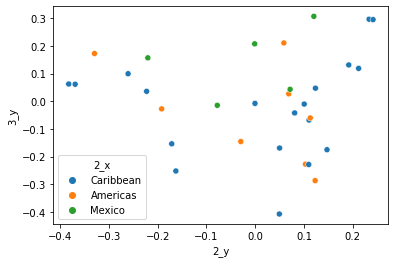

In [51]:
# ¿hay clústers en las poblaciones?
sb.scatterplot(data=clusters, x="2_y", y="3_y", hue="2_x")

<AxesSubplot:ylabel='0'>

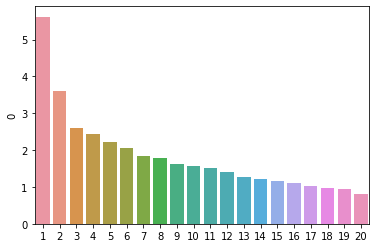

In [50]:
# ¿qué varianza explican cada componente?
perc = pd.read_csv("plink/pca.eigenval", sep=' ', header=None)
perc["PC"]=list(range(1,21))
sb.barplot(data=perc,x=pc, y=0)